# Airbnb New User Destination Bookings¶

## Investigation Overview

> We will analyze some Airbnb data about its customers and users’ behavior over Airbnb platform and the main goal is to predict the new user’s booking destination.

## Dataset Overview

-train_users.csv - the training set of users

-test_users.csv - the test set of users

affiliate_channel: what kind of paid marketing

affiliate_provider: where the marketing is e.g. google, craigslist, other

country_destination: this is the target variable you are to predict

-countries.csv - summary statistics of destination countries in this dataset and their locations
-age_gender_bkts.csv - summary statistics of users' age group, gender, country of destination
-sample_submission.csv - correct format for submitting your predictions.


In [367]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.stats import chi2_contingency
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import statistics
import operator
from sklearn.metrics import ndcg_score
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [368]:
df_gender= pd.read_csv('age_gender_bkts.csv')
df_gender.sample(6)

,age_bucket,country_destination,gender,population_in_thousands,year
262,50-54,IT,male,2322.0,2015.0
282,70-74,IT,female,1567.0,2015.0
98,30-34,DE,female,2571.0,2015.0
142,80-84,ES,female,843.0,2015.0
1,95-99,AU,male,9.0,2015.0
3,85-89,AU,male,118.0,2015.0


In [369]:
df_gender.nunique()

age_bucket                  21
country_destination         10
gender                       2
population_in_thousands    381
year                         1
dtype: int64

In [370]:
df_gender.info()
print(df_gender.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age_bucket               420 non-null    object 
 1   country_destination      420 non-null    object 
 2   gender                   420 non-null    object 
 3   population_in_thousands  420 non-null    float64
 4   year                     420 non-null    float64
dtypes: float64(2), object(3)
memory usage: 16.5+ KB
(420, 5)


In [371]:
np.sum(df_gender.isnull())

age_bucket                 0
country_destination        0
gender                     0
population_in_thousands    0
year                       0
dtype: int64

In [372]:
df_gender.age_bucket.value_counts().sort_index()

0-4      20
10-14    20
100+     20
15-19    20
20-24    20
25-29    20
30-34    20
35-39    20
40-44    20
45-49    20
5-9      20
50-54    20
55-59    20
60-64    20
65-69    20
70-74    20
75-79    20
80-84    20
85-89    20
90-94    20
95-99    20
Name: age_bucket, dtype: int64

In [373]:
df_gender.country_destination.value_counts()

IT    42
ES    42
NL    42
DE    42
PT    42
GB    42
CA    42
FR    42
AU    42
US    42
Name: country_destination, dtype: int64

In [374]:
df_session = pd.read_csv('sessions.csv')
df_session.sample(6)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
6696505,aaetksikaz,similar_listings_v2,NaN,NaN,Windows Desktop,55.0
8253213,bkgg2myiyp,profile_pic,-unknown-,-unknown-,Mac Desktop,321.0
7631417,e8xve44yab,search_results,click,view_search_results,Windows Desktop,10437.0
7921548,nahe7g6n4f,personalize,data,wishlist_content_update,Mac Desktop,81.0
4336784,0mncva4ge2,show,view,p3,Mac Desktop,83.0
2993454,8xa7kke2p9,index,view,view_search_results,Mac Desktop,8786.0


In [375]:
df_country = pd.read_csv('countries.csv')
df_country.sample(6)

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
9,US,36.966427,-95.844030,0.0000,9826675.0,eng,0.00
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25


In [376]:
df_train = pd.read_csv('train_users_2.csv')
df_train.sample(6)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
110148,rnuia1rusf,2013-09-23,20130923035926,NaN,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,NDF
30989,bw4zlssm8y,2012-07-08,20120708201221,2013-03-05,FEMALE,39.0,basic,0,en,other,other,tracked-other,Web,Mac Desktop,Safari,other
93843,ah9afcvibz,2013-07-25,20130725034025,NaN,FEMALE,38.0,basic,0,en,direct,direct,untracked,Web,Windows Desktop,IE,NDF
185674,7155kvi7yj,2014-05-07,20140507051038,NaN,-unknown-,NaN,basic,0,en,seo,google,linked,Web,iPad,Mobile Safari,NDF
97189,8mlxyt66zv,2013-08-07,20130807000547,NaN,MALE,29.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
213067,vb6qxtp1x0,2014-06-30,20140630063227,NaN,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,NDF


In [377]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       213451 non-null  object 
 1   date_account_created     213451 non-null  object 
 2   timestamp_first_active   213451 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   213451 non-null  object 
 5   age                      125461 non-null  float64
 6   signup_method            213451 non-null  object 
 7   signup_flow              213451 non-null  int64  
 8   language                 213451 non-null  object 
 9   affiliate_channel        213451 non-null  object 
 10  affiliate_provider       213451 non-null  object 
 11  first_affiliate_tracked  207386 non-null  object 
 12  signup_app               213451 non-null  object 
 13  first_device_type        213451 non-null  object 
 14  firs

<AxesSubplot:>

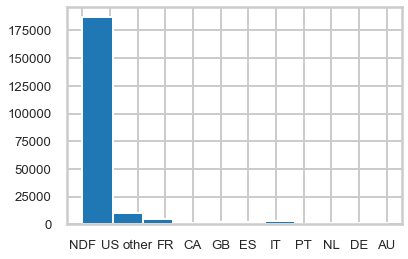

In [378]:
df_train.country_destination.hist()

In [379]:
np.sum(df_train.isnull())

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [380]:
df_train.first_browser.value_counts()

Chrome                  63845
Safari                  45169
Firefox                 33655
-unknown-               27266
IE                      21068
Mobile Safari           19274
Chrome Mobile            1270
Android Browser           851
AOL Explorer              245
Opera                     188
Silk                      124
Chromium                   73
BlackBerry Browser         53
Maxthon                    46
Apple Mail                 36
IE Mobile                  36
Sogou Explorer             33
Mobile Firefox             30
SiteKiosk                  24
RockMelt                   24
Iron                       17
IceWeasel                  13
Pale Moon                  12
SeaMonkey                  11
CometBird                  11
Yandex.Browser             11
Camino                      9
TenFourFox                  8
wOSBrowser                  6
CoolNovo                    6
Opera Mini                  4
Avant Browser               4
Mozilla                     3
Flock     

In [381]:
df_train.gender.value_counts()

-unknown-    95688
FEMALE       63041
MALE         54440
OTHER          282
Name: gender, dtype: int64

In [382]:
df_train.age.describe() #age has many outliers

count    125461.000000
mean         49.668335
std         155.666612
min           1.000000
25%          28.000000
50%          34.000000
75%          43.000000
max        2014.000000
Name: age, dtype: float64

In [383]:
df_train.shape

(213451, 16)

In [384]:
df_train[df_train['age']>110].count()

id                         801
date_account_created       801
timestamp_first_active     801
date_first_booking         382
gender                     801
age                        801
signup_method              801
signup_flow                801
language                   801
affiliate_channel          801
affiliate_provider         801
first_affiliate_tracked    766
signup_app                 801
first_device_type          801
first_browser              801
country_destination        801
dtype: int64

In [385]:
df_train[df_train.age<16].count()

id                         65
date_account_created       65
timestamp_first_active     65
date_first_booking         17
gender                     65
age                        65
signup_method              65
signup_flow                65
language                   65
affiliate_channel          65
affiliate_provider         65
first_affiliate_tracked    46
signup_app                 65
first_device_type          65
first_browser              65
country_destination        65
dtype: int64

In [386]:
df_train.date_first_booking.value_counts().sort_index()

2010-01-02    1
2010-01-04    1
2010-01-05    1
2010-01-06    1
2010-01-08    1
             ..
2015-06-23    1
2015-06-25    1
2015-06-26    1
2015-06-28    1
2015-06-29    1
Name: date_first_booking, Length: 1976, dtype: int64

In [387]:
df_train.isnull().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [388]:
df_test = pd.read_csv('test_users.csv')
df_test.sample(6)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
3501,2m6mxo9gaj,2014-07-07,20140707152646,NaN,MALE,45.0,basic,0,en,direct,direct,linked,Web,Mac Desktop,Safari
19252,9ws7qhfcjw,2014-07-28,20140728220847,NaN,MALE,NaN,facebook,0,en,direct,direct,product,Web,Mac Desktop,Safari
16992,tw7jyc4d9h,2014-07-25,20140725185804,NaN,MALE,37.0,basic,0,en,direct,direct,untracked,Web,iPad,Mobile Safari
53891,o2snp7jppz,2014-09-17,20140917164019,NaN,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-
22903,6oo890cefy,2014-08-02,20140802215726,NaN,FEMALE,46.0,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari
31150,1jajzwpjjy,2014-08-14,20140814044549,NaN,-unknown-,NaN,basic,0,en,sem-non-brand,google,omg,Web,iPad,Mobile Safari


In [389]:
df_test.isnull().sum()

id                             0
date_account_created           0
timestamp_first_active         0
date_first_booking         62096
gender                         0
age                        28876
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked       20
signup_app                     0
first_device_type              0
first_browser                  0
dtype: int64

In [390]:
df_test.shape

(62096, 15)

In [391]:
#Concate train & test
df_final= pd.concat([df_train,df_test],axis=0)
df_final.shape

(275547, 16)

## Data Cleaning

In [392]:
df_copy = df_final.copy()

In [393]:
#For train data we will fill the age nan and outliers "<110 & >16" with the mean 
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 275547 entries, 0 to 62095
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       275547 non-null  object 
 1   date_account_created     275547 non-null  object 
 2   timestamp_first_active   275547 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   275547 non-null  object 
 5   age                      158681 non-null  float64
 6   signup_method            275547 non-null  object 
 7   signup_flow              275547 non-null  int64  
 8   language                 275547 non-null  object 
 9   affiliate_channel        275547 non-null  object 
 10  affiliate_provider       275547 non-null  object 
 11  first_affiliate_tracked  269462 non-null  object 
 12  signup_app               275547 non-null  object 
 13  first_device_type        275547 non-null  object 
 14  first

In [394]:
#df_copy.isnull().sum()
#Finding the number of null entries in each column.
for col in df_copy.columns:
    null_values = df_copy[col].isnull().sum()
    if null_values != 0:
        print( " '{}' has {} null values.".format(col,null_values))
        print() # for a whitespace format only
print('shape is: ', df_copy.shape)


 'date_first_booking' has 186639 null values.

 'age' has 116866 null values.

 'first_affiliate_tracked' has 6085 null values.

 'country_destination' has 62096 null values.

shape is:  (275547, 16)


In [395]:
df_copy[(df_copy.age<110)&(df_copy.age>16)].age.mean() #mean of normal age is 37
Value=37.0

In [396]:
#fill the null and outliers values with mean age
df_copy.loc[df_copy.age>110,'age']=37.0 
df_copy.loc[df_copy.age<16,'age']=37.0
df_copy.age.fillna(value = Value,inplace=True)
df_copy.sample(20)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
122986,gm2j2na9d4,2013-11-08,20131108231317,2014-08-21,FEMALE,25.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari,US
68087,b1y4bgc1k7,2013-03-30,20130330155041,NaN,-unknown-,37.0,basic,0,en,direct,direct,linked,Web,Mac Desktop,Chrome,NDF
22311,kxbzz3e7j9,2014-08-01,20140801213859,NaN,MALE,41.0,facebook,0,en,direct,direct,untracked,Web,Windows Desktop,IE,NaN
18544,7d7115vvsm,2014-07-27,20140727231748,NaN,-unknown-,37.0,basic,25,en,direct,direct,untracked,iOS,Mac Desktop,Safari,NaN
20792,nk2gsd3j9d,2012-04-08,20120408195917,NaN,MALE,44.0,facebook,0,en,other,other,untracked,Web,iPhone,Chrome Mobile,NDF
157132,e4hb9hvzw8,2014-02-26,20140226084622,2014-05-01,-unknown-,37.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari,other
40056,n7sv54vcar,2012-09-08,20120908142930,NaN,MALE,37.0,basic,0,fr,direct,direct,linked,Web,Windows Desktop,Firefox,NDF
115207,9jv5y94p6r,2013-10-08,20131008164929,NaN,MALE,105.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
98376,flevj4wg1v,2013-08-11,20130811064612,2013-08-11,FEMALE,35.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari,US
100197,brh9pf137x,2013-08-17,20130817204935,NaN,-unknown-,37.0,basic,0,en,direct,direct,untracked,Web,Windows Desktop,IE,NDF


In [397]:
#df_copy['age'] = df_copy['age'].apply(lambda x: '37' if x == 'NaN' else x)

In [398]:
df_copy.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         186639
gender                          0
age                             0
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6085
signup_app                      0
first_device_type               0
first_browser                   0
country_destination         62096
dtype: int64

In [399]:
np.sum(df_copy[df_copy['country_destination']!='NDF']['date_first_booking'].isna())

62096

In [400]:
#there's no missing value for first booking date column when there is booking done

In [401]:
df_copy.first_affiliate_tracked.describe() #untracked is the most frequent, we could fill with mode 

count        269462
unique            7
top       untracked
freq         143181
Name: first_affiliate_tracked, dtype: object

<AxesSubplot:>

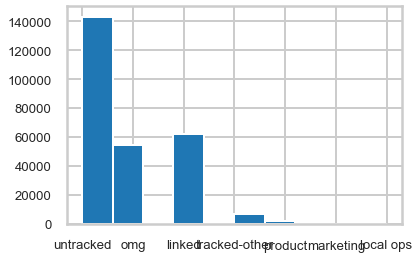

In [402]:
df_copy.first_affiliate_tracked.hist()

In [403]:
df_copy['first_affiliate_tracked'] = df_copy['first_affiliate_tracked'].fillna(df_copy['first_affiliate_tracked'].mode().values[0])

In [404]:
df_copy.first_affiliate_tracked.value_counts()

untracked        149266
linked            62064
omg               54859
tracked-other      6655
product            2353
marketing           281
local ops            69
Name: first_affiliate_tracked, dtype: int64

In [405]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 275547 entries, 0 to 62095
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       275547 non-null  object 
 1   date_account_created     275547 non-null  object 
 2   timestamp_first_active   275547 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   275547 non-null  object 
 5   age                      275547 non-null  float64
 6   signup_method            275547 non-null  object 
 7   signup_flow              275547 non-null  int64  
 8   language                 275547 non-null  object 
 9   affiliate_channel        275547 non-null  object 
 10  affiliate_provider       275547 non-null  object 
 11  first_affiliate_tracked  275547 non-null  object 
 12  signup_app               275547 non-null  object 
 13  first_device_type        275547 non-null  object 
 14  first

In [406]:
#Changing the format of date_account_created to datetime
df_copy.date_account_created=pd.to_datetime(df_copy.date_account_created)
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 275547 entries, 0 to 62095
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   id                       275547 non-null  object        
 1   date_account_created     275547 non-null  datetime64[ns]
 2   timestamp_first_active   275547 non-null  int64         
 3   date_first_booking       88908 non-null   object        
 4   gender                   275547 non-null  object        
 5   age                      275547 non-null  float64       
 6   signup_method            275547 non-null  object        
 7   signup_flow              275547 non-null  int64         
 8   language                 275547 non-null  object        
 9   affiliate_channel        275547 non-null  object        
 10  affiliate_provider       275547 non-null  object        
 11  first_affiliate_tracked  275547 non-null  object        
 12  signup_app       

In [407]:
df_copy['AccCreat_year']=df_copy.date_account_created.dt.year
df_copy['AccCreat_Month']=df_copy.date_account_created.dt.month
df_copy['AccCreat_Day']=df_copy.date_account_created.dt.day

In [408]:
df_copy.drop(['date_first_booking'],axis=1,inplace=True)

In [409]:
df_copy.sample(6)

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,AccCreat_year,AccCreat_Month,AccCreat_Day
152321,0nwnuy9age,2014-02-13,20140213000454,-unknown-,28.0,basic,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,2014,2,13
26866,cs0o8fqrsn,2014-08-08,20140808061012,-unknown-,18.0,basic,0,en,direct,direct,omg,Web,iPad,Chrome Mobile,NaN,2014,8,8
7534,q7ss6qsp1o,2014-07-14,20140714192601,FEMALE,31.0,basic,25,en,direct,direct,linked,iOS,iPhone,Mobile Safari,NaN,2014,7,14
45111,x6ephgal4r,2012-10-17,20121017033720,FEMALE,30.0,basic,0,en,direct,direct,omg,Web,Mac Desktop,Safari,NDF,2012,10,17
22280,sgojtzgze5,2012-04-25,20120425100621,MALE,25.0,facebook,3,en,sem-non-brand,vast,untracked,Web,Other/Unknown,-unknown-,NDF,2012,4,25
38485,qa4wr4cu4z,2012-08-28,20120828211602,FEMALE,37.0,basic,0,en,sem-brand,google,linked,Web,iPhone,Mobile Safari,IT,2012,8,28


In [410]:
#df.country_destination

## Data Exploration

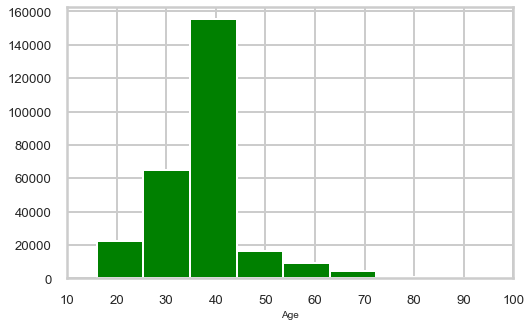

In [411]:
plt.figure(figsize=(8, 5))
df_copy.age.hist(color='g')
plt.xlim(10, 100)
plt.xlabel("Age", size=10)
#plt.title('Cancelled Reason Distribution by Carrier', size=15)
plt.show(); #majority almost from 25 or late 20s till 45 using airbnb 

In [412]:
df_copy.signup_app.value_counts()

Web        219918
iOS         34593
Android     10519
Moweb       10517
Name: signup_app, dtype: int64

In [413]:
df_copy.country_destination.value_counts() #NDF: no destination found which is no booking is done

NDF      124543
US        62376
other     10094
FR         5023
IT         2835
GB         2324
ES         2249
CA         1428
DE         1061
NL          762
AU          539
PT          217
Name: country_destination, dtype: int64

Text(0.5, 1.0, 'Airbnb Gender Data')

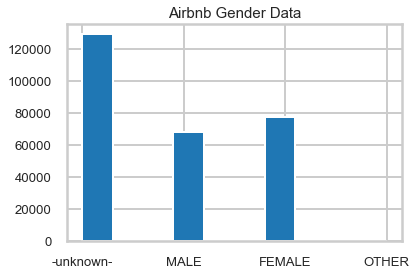

In [414]:
Age=df_copy.gender
Age.hist()
plt.title('Airbnb Gender Data', size=15)
#the unknown is a majority here!, let's analyze to see what could we do about it.

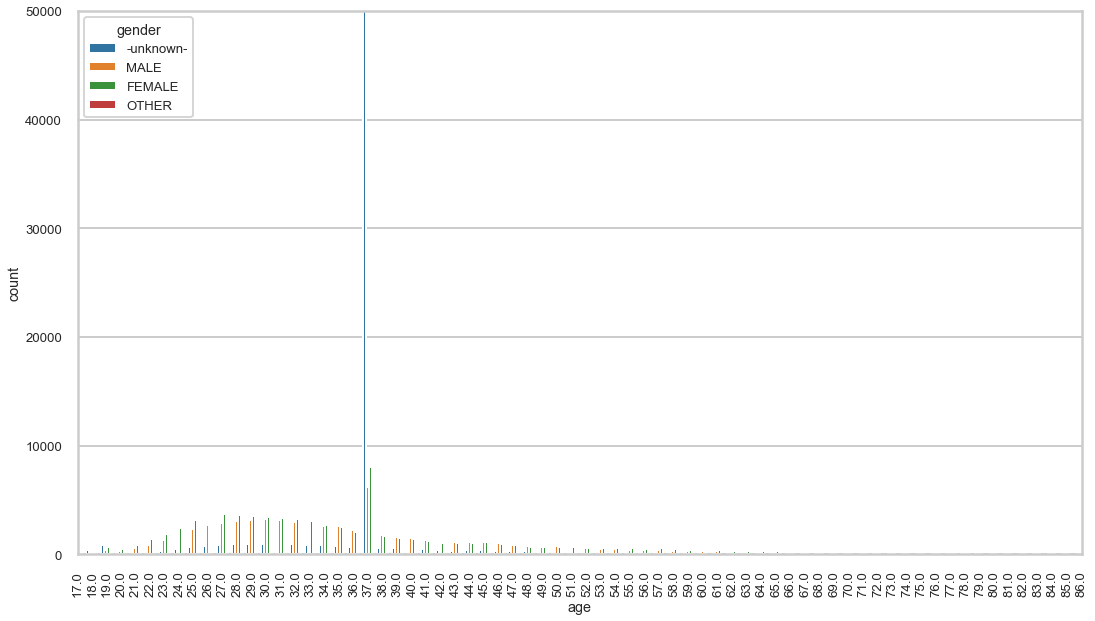

In [415]:
#See gender bias with age:
plt.figure(figsize=(18,10))
plt.xticks(rotation=90)
#Unknown= df_copy.query('gender=="-unknown-"')
#Unknown
plt.ylim(0, 50000)
sns.countplot(x='age',data=df_copy,hue='gender').set_xlim(1,70);



<AxesSubplot:xlabel='affiliate_channel', ylabel='count'>

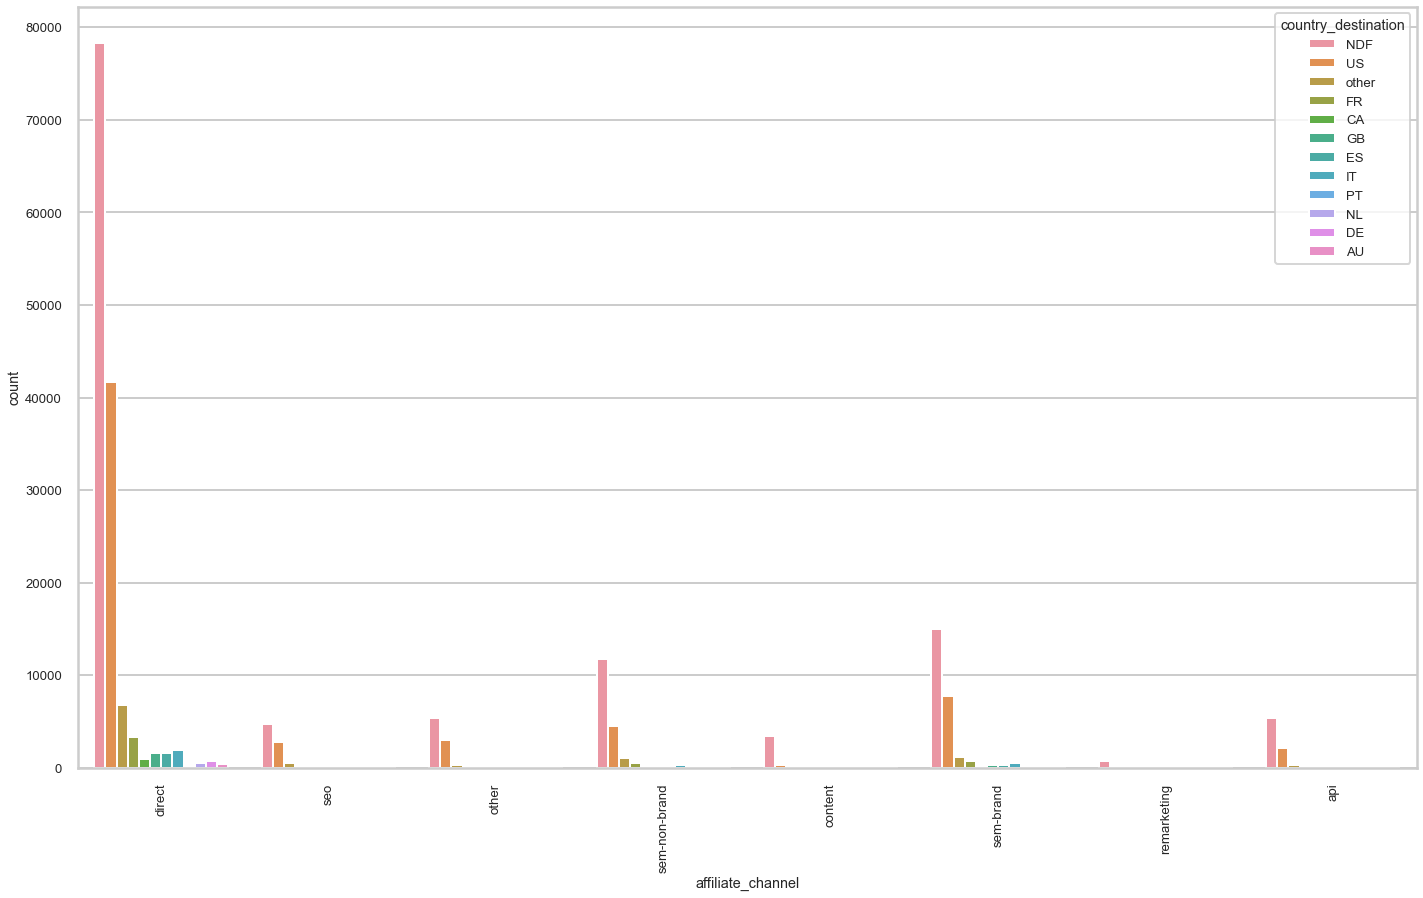

In [416]:
plt.figure(figsize=(24,14))
plt.xticks(rotation=90)
#Gender bias with country_distination:
sns.countplot(x='affiliate_channel',data=df_copy,hue='country_destination')



<AxesSubplot:xlabel='affiliate_channel', ylabel='count'>

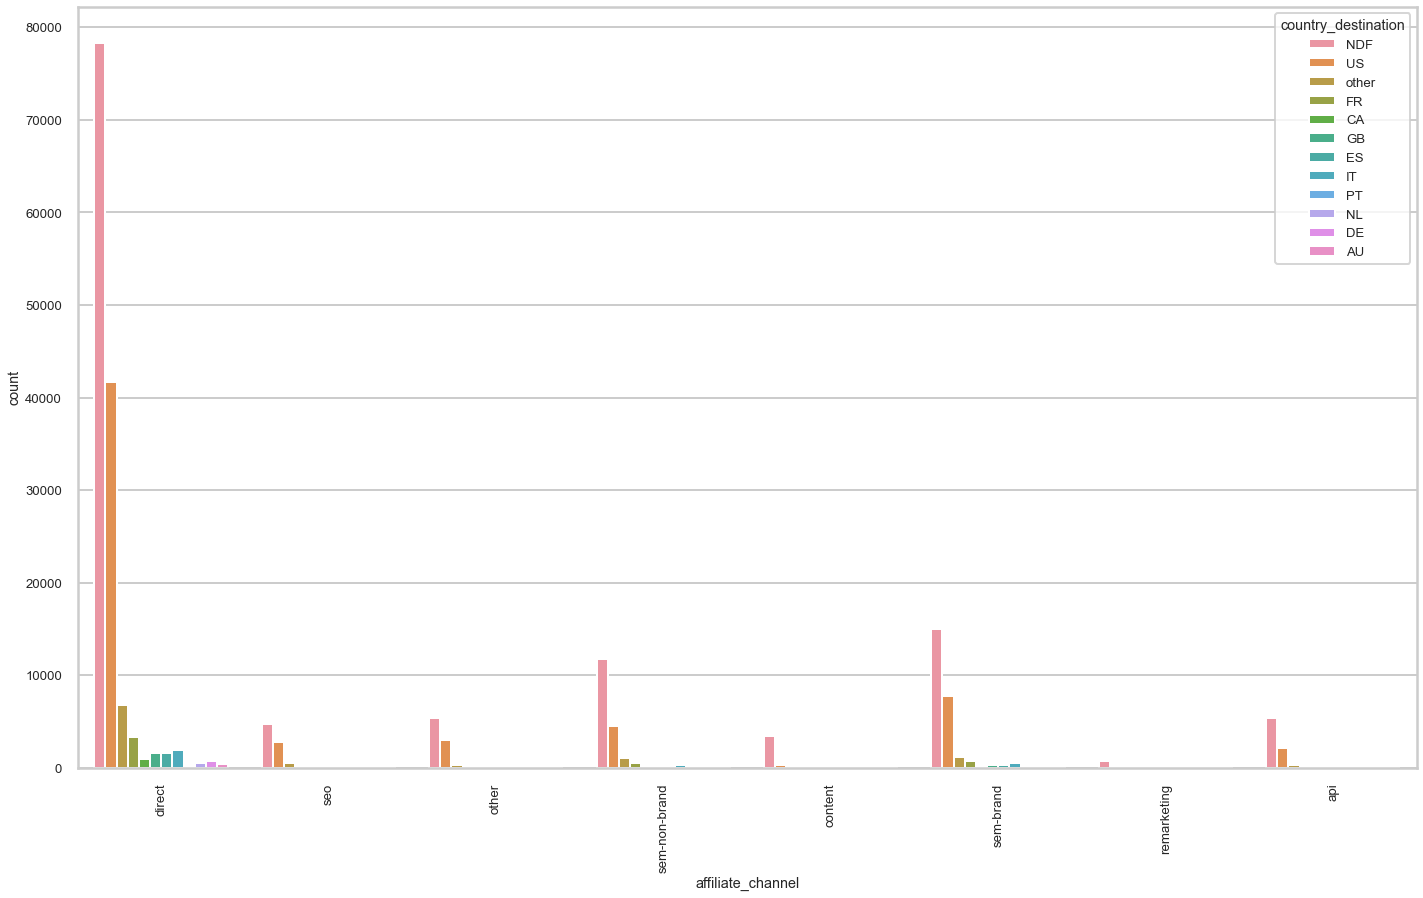

In [417]:
plt.figure(figsize=(24,14))
plt.xticks(rotation=90)
#Gender bias with country_distination:
sns.countplot(x='affiliate_channel',data=df_copy,hue='country_destination')

<Figure size 1440x1872 with 0 Axes>

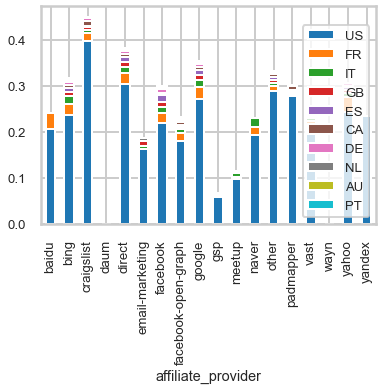

In [418]:
plt.figure(figsize=(20,26))
Country_order=['US','FR','IT','GB','ES','CA','DE','NL','AU','PT']
ctab = pd.crosstab([df_copy['affiliate_provider']], df_copy.country_destination).apply(lambda x: x/x.sum(), axis=1) #precentage to get the small values for providers
ctab[Country_order].plot(kind='bar', stacked=True)
plt.legend(loc='lower right');

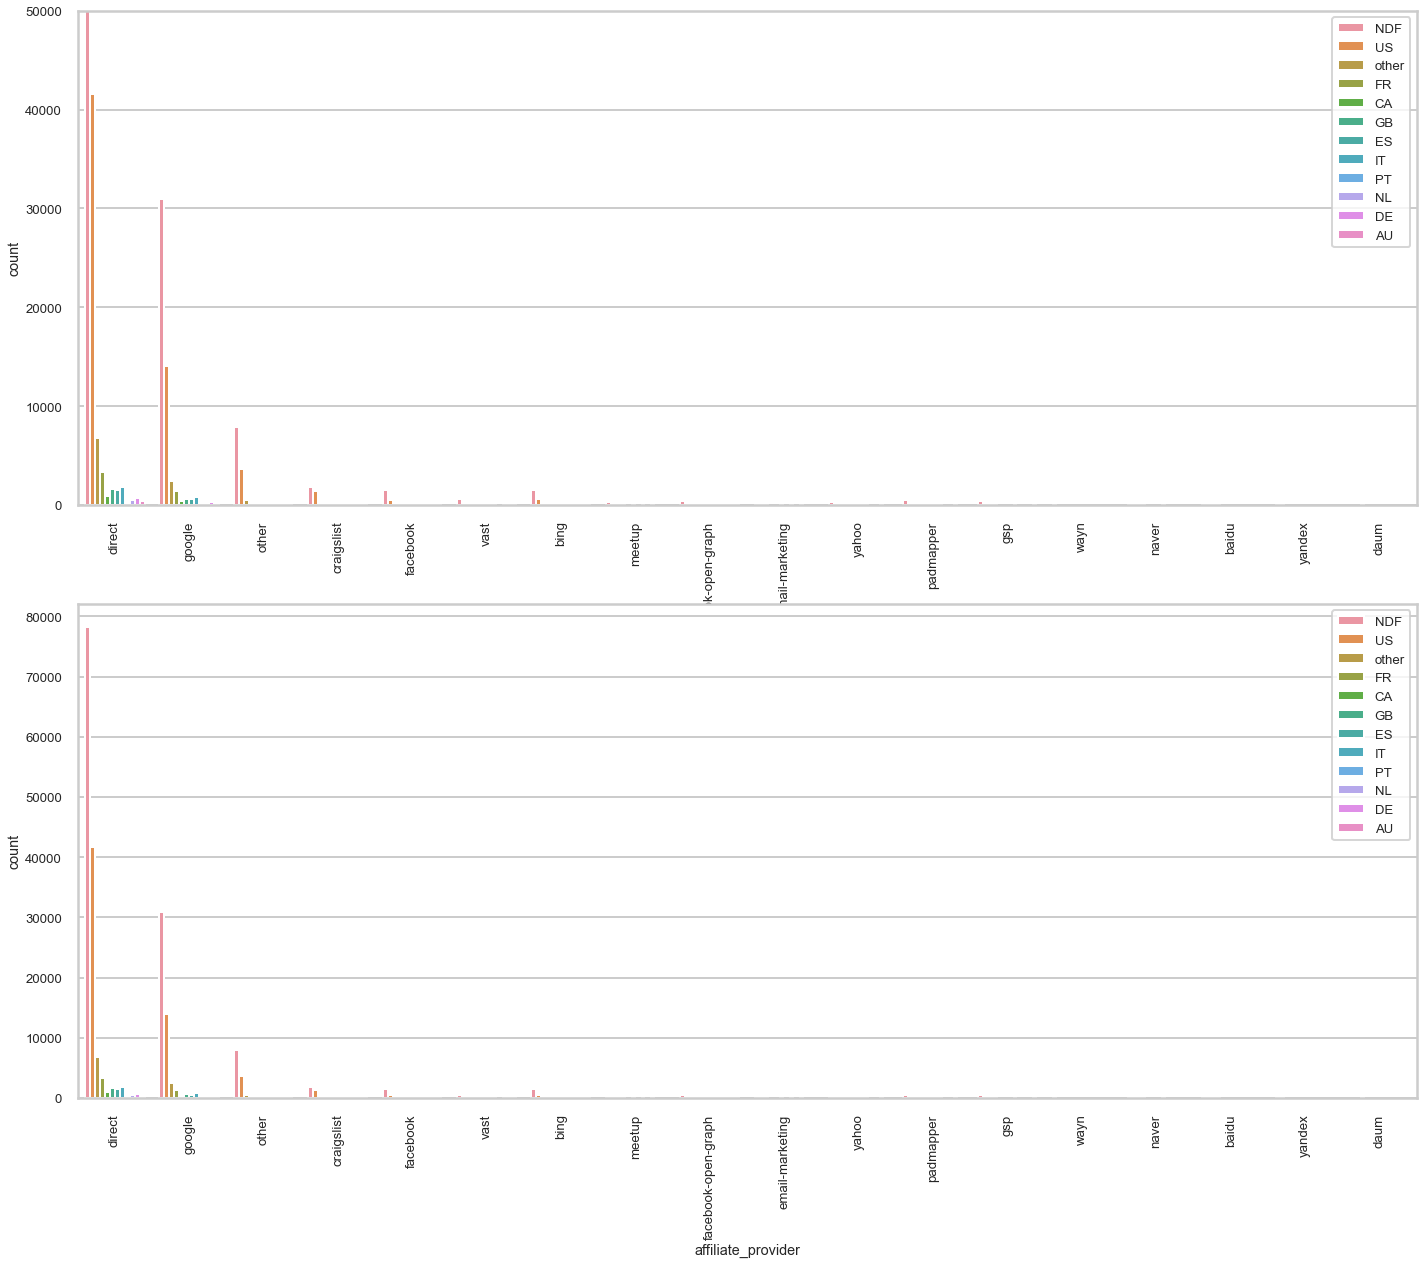

In [419]:
plt.figure(figsize=(24,20))
#plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
plt.ylim(0, 50000)
plt.xticks(rotation=90)
sns.countplot(x='affiliate_provider',data=df_copy,hue='country_destination')
plt.legend(loc='upper right')

plt.subplot(2, 1, 2)
plt.xticks(rotation=90)
#Gender bias with country_distination:
sns.countplot(x='affiliate_provider',data=df_copy,hue='country_destination')
plt.legend(loc='upper right');


The Direct Channel has the most number of conversions to bookings as well as leads to the most number of users have NDf.
Direct and Google are the most popular affiliate providers.Also Craigslist has a good percentage of conversions. 
Facebook & Bing should be well tested why their channels has close numbers of NDF and real bookings.
Also channels like gsp, baidu and others should be taken in consideration if they shouldn't contiue dealing with those affiliate providers based on the very few conversion rates.



<AxesSubplot:xlabel='gender', ylabel='count'>

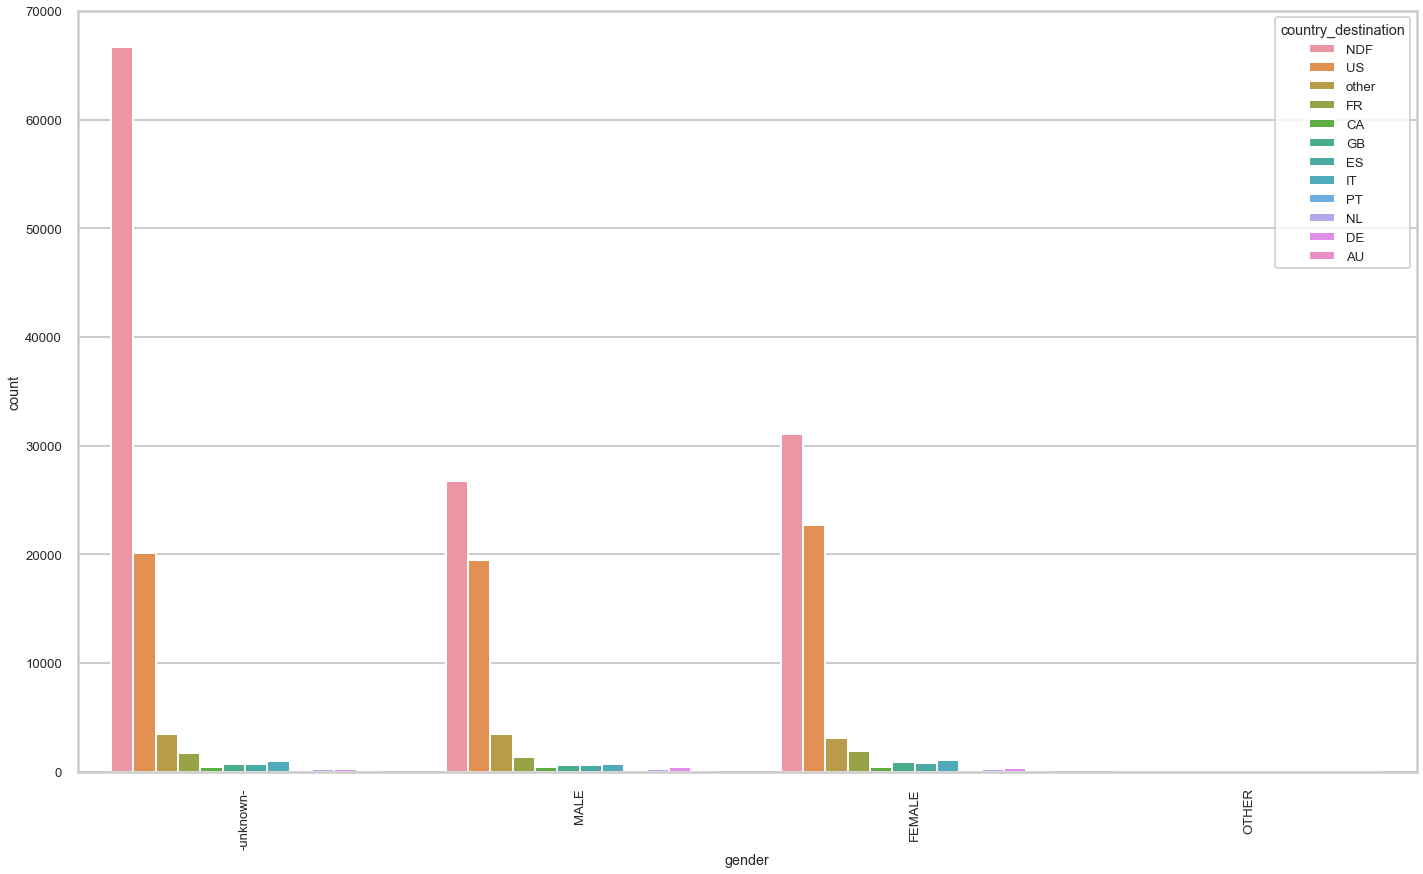

In [420]:
plt.figure(figsize=(24,14))
plt.xticks(rotation=90)
#Gender bias with country_distination:
sns.countplot(x='gender',data=df_copy,hue='country_destination')

#### Here we see that most of NDF is chosen by unknown, which means that if we remove the unknown, it won't affect the booking destination at least now. 
After exploration some data, it turns out data needs to be less noissy which means I could clear more misleading values such as unknown in gender column and NDF "no distination found" since no booking will happen regarding this value. This will be useful at our model.
number of NDF seems to be very large one, the reason why might be due to large number uses airbnb for browsing and exploration, another reason is that some of the marketing channels are not quite useful and get the wrong target audience.

In [421]:
df_copy2 = df_copy[(df_copy['country_destination'] != 'NDF') & (df_copy['gender'] != '-unknown-')]
#df_copy = df_copy[['id', 'gender', 'country_destination']]
df_copy2.head()

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,AccCreat_year,AccCreat_Month,AccCreat_Day
2,4ft3gnwmtx,2010-09-28,20090609231247,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,2010,9,28
3,bjjt8pjhuk,2011-12-05,20091031060129,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,2011,12,5
6,lsw9q7uk0j,2010-01-02,20100102012558,FEMALE,46.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US,2010,1,2
7,0d01nltbrs,2010-01-03,20100103191905,FEMALE,47.0,basic,0,en,direct,direct,omg,Web,Mac Desktop,Safari,US,2010,1,3
8,a1vcnhxeij,2010-01-04,20100104004211,FEMALE,50.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US,2010,1,4


In [422]:
df_copy2.isnull().sum()

id                             0
date_account_created           0
timestamp_first_active         0
gender                         0
age                            0
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked        0
signup_app                     0
first_device_type              0
first_browser                  0
country_destination        28304
AccCreat_year                  0
AccCreat_Month                 0
AccCreat_Day                   0
dtype: int64

In [423]:
df_copy2.info()
#Here test data starts 59891:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88194 entries, 2 to 62095
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       88194 non-null  object        
 1   date_account_created     88194 non-null  datetime64[ns]
 2   timestamp_first_active   88194 non-null  int64         
 3   gender                   88194 non-null  object        
 4   age                      88194 non-null  float64       
 5   signup_method            88194 non-null  object        
 6   signup_flow              88194 non-null  int64         
 7   language                 88194 non-null  object        
 8   affiliate_channel        88194 non-null  object        
 9   affiliate_provider       88194 non-null  object        
 10  first_affiliate_tracked  88194 non-null  object        
 11  signup_app               88194 non-null  object        
 12  first_device_type        88194 n

In [424]:
df_copy2.gender.value_counts()

FEMALE    46476
MALE      41490
OTHER       228
Name: gender, dtype: int64

In [425]:
df_copy2['country_destination'].value_counts()

US       42267
other     6625
FR        3310
IT        1795
GB        1566
ES        1534
CA         937
DE         777
NL         535
AU         396
PT         148
Name: country_destination, dtype: int64

In [426]:
df_copy2['language'].value_counts()


en    85200
zh      765
fr      486
es      352
ko      301
de      290
ru      163
it      162
ja      128
pt      109
sv       65
nl       38
tr       32
da       23
pl       20
no       15
cs       11
fi       10
el        9
th        5
hu        4
ca        3
is        2
id        1
Name: language, dtype: int64

### let's back again to the Data Exploration:

In [427]:
#seems we have number of females more than the number of males.
#Most destination is in USA

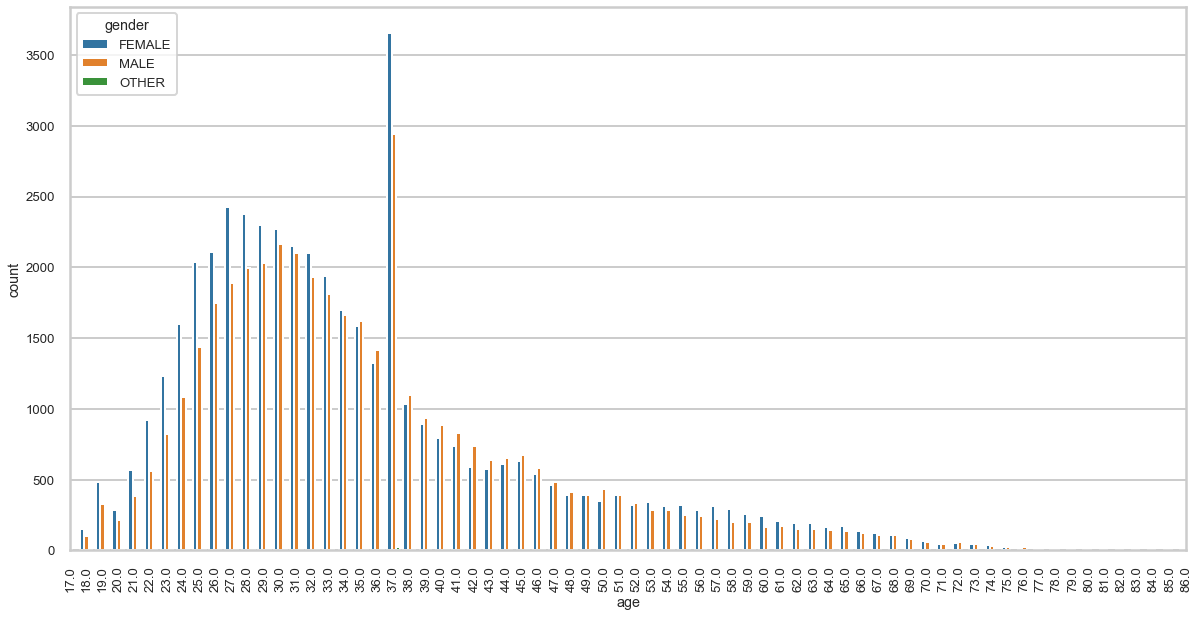

In [428]:
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
#Unknown= df_copy.query('gender=="-unknown-"')
#Unknown
sns.countplot(x='age',data=df_copy2,hue='gender').set_xlim(1,70);
#to assure female are more than male numbers almost over the highest ages use airbnb 

C:\Users\AbouElNasrA\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


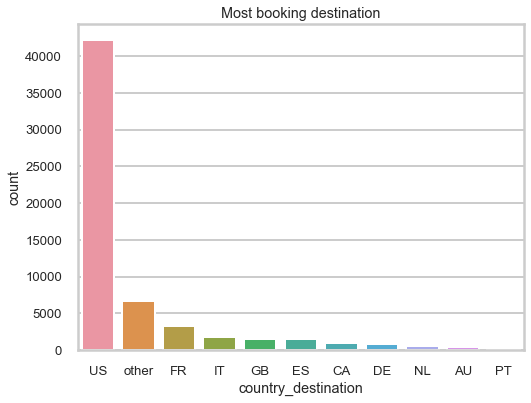

In [429]:
plt.figure(figsize=(8,6))
sns.countplot('country_destination', order = df_copy2['country_destination'].value_counts().index, data=df_copy2 )
plt.title('Most booking destination');

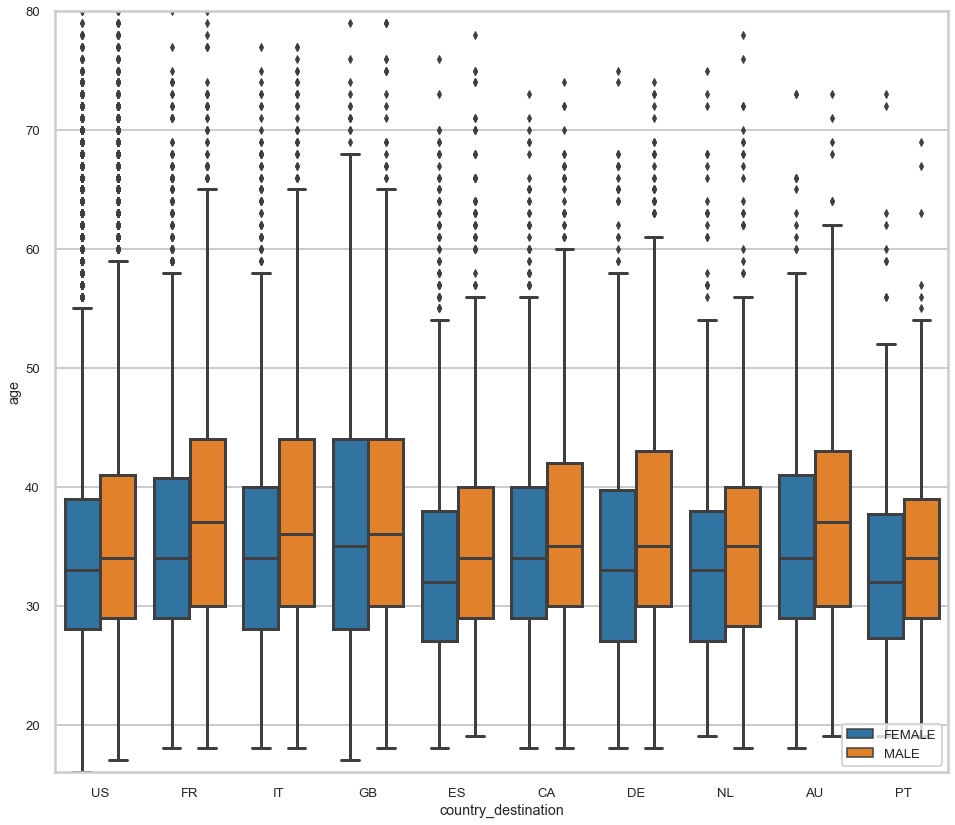

In [430]:
sns.set_style("whitegrid")
plt.figure(figsize=(16, 14))
Country_order=['US','FR','IT','GB','ES','CA','DE','NL','AU','PT']
Gender=df_copy2[(df_copy2['gender'] != 'OTHER')]
sns.boxplot(x='country_destination', y='age', hue='gender', data=Gender, order=Country_order)
plt.ylim(16, 80)
plt.legend(loc='lower right')
plt.show()

We could see here in USA gender age booking is almost close to each other, but the interesting insight that age range higher is when it come to Britin as a booking distination and on the contrary, span is attractive to the young people especially females.
Also there's a gap between female and male age when it comes to Italy, older age of male users book in Italy on airbnb.
Also, on interesting insight it seems like airbnb is used more often by almost 30th and 40th people, more than the younger ones!

#Lets make sure of the hypothsis above for male and female only if there is a country ditination bias by the gender as it's hard to tell the distenation is contingent upon or depends upon the gender from numbers alone:

Null Hypothesis: There is no relationship between country preference and the gender of the customer.

Alternate Hypothesis: There is a relationship between country preference and the gender of the customer.

    alfa is 0.05
    
since we have a categorical variables, we need to test 1 variable with mutivariables, we'll use Chi-square test.

In [431]:

#pivot to get contingency table
Table1 = df_copy2.pivot_table('id', ['gender'], 'country_destination', aggfunc='count').reset_index()
#del observed.columns.name
Table1 = Table1.set_index('gender')
Table1

country_destination,AU,CA,DE,ES,FR,GB,IT,NL,PT,US,other
gender,,,,,,,,,,,
FEMALE,207,455,358,853,1962,881,1091,254,78,22694,3160
MALE,188,477,416,677,1335,682,699,278,69,19457,3443
OTHER,1,5,3,4,13,3,5,3,1,116,22


In [432]:
chi2, p, dof, expected = stats.chi2_contingency(Table1)

In [433]:
print(chi2)
print(dof)
print(p)

220.87966758097264
20
7.970832529945862e-36


no significant result, reject null hypothesis (H0). This means There is a relationship between country preference and the sex of the customer.

In [434]:
#chi2, p, dof, ex = chi2_contingency(Table1, correction=False)
#print(chi2, p)

In [435]:
df_copy2['AccCreat_year'].value_counts()

2014    46988
2013    22675
2012    13819
2011     3919
2010      793
Name: AccCreat_year, dtype: int64

C:\Users\AbouElNasrA\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


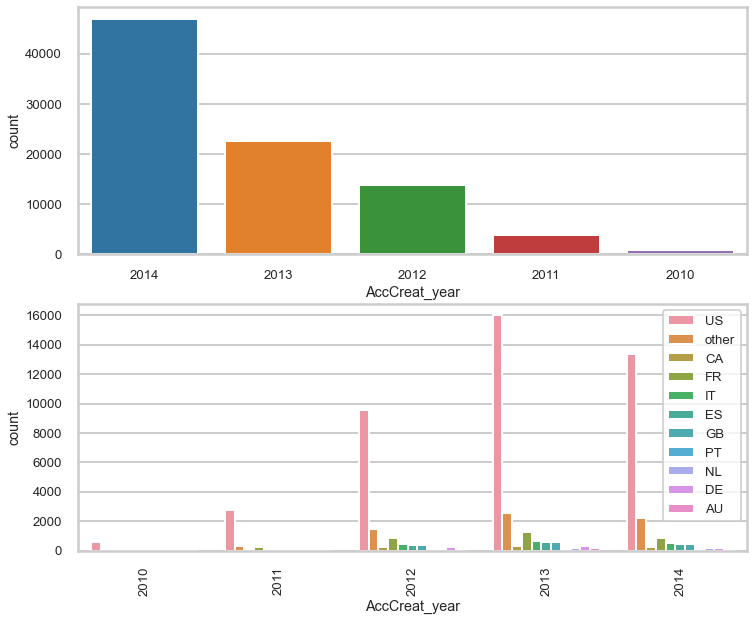

In [436]:
#plt.figure(figsize=(20,10))
plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
sns.countplot('AccCreat_year', order = df_copy2['AccCreat_year'].value_counts().index, data=df_copy2 )
#plot_histogram(df_copy2['AccCreat_year'])
plt.subplot(2, 1, 2)
plt.xticks(rotation=90)
#Unknown= df_copy.query('gender=="-unknown-"')
#Unknown
sns.countplot(x='AccCreat_year',data=df_copy2,hue='country_destination');
plt.legend(bbox_to_anchor=(1.0, 1.0));
#to assure female are more than male numbers almost over the highest ages use airbnb 

<Figure size 864x432 with 0 Axes>

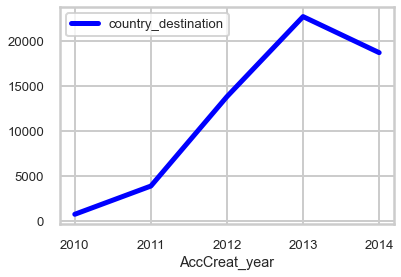

In [437]:
sns.set_style("whitegrid")
sns.set_context("poster", font_scale=0.6)
plt.figure(figsize=(12,6))
#plt.xticks(rotation=90)
df_copy2[['AccCreat_year','country_destination']].groupby(['AccCreat_year']).count().plot(kind='line', linewidth=5, color='blue');

In [438]:
#Most account creation year was in 2014, also the booking distination has the max effect on 2013 in US and FR.

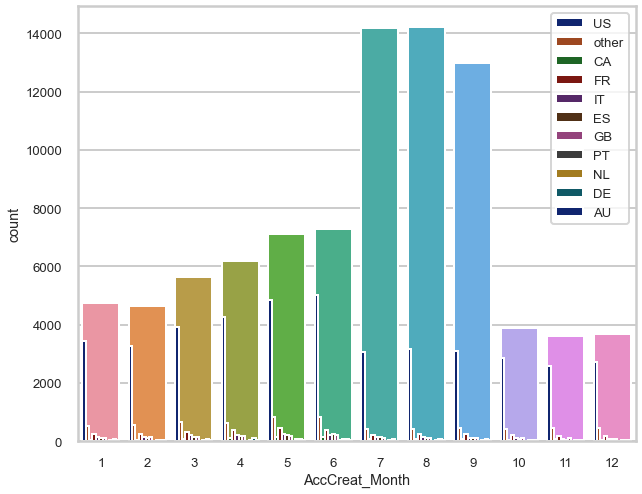

In [439]:
plt.figure(figsize=(10,8))
#sns.countplot(x='AccCreat_Month',data=df_copy2,hue='country_destination').set_ylim(0,1000)
sns.countplot(x='AccCreat_Month',data=df_copy2)
sns.countplot(x='AccCreat_Month',data=df_copy2 ,hue='country_destination',palette='dark');
plt.legend(bbox_to_anchor=(1.0, 1.0));

C:\Users\AbouElNasrA\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\AbouElNasrA\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\AbouElNasrA\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='first_affiliate_tracked', ylabel='count'>

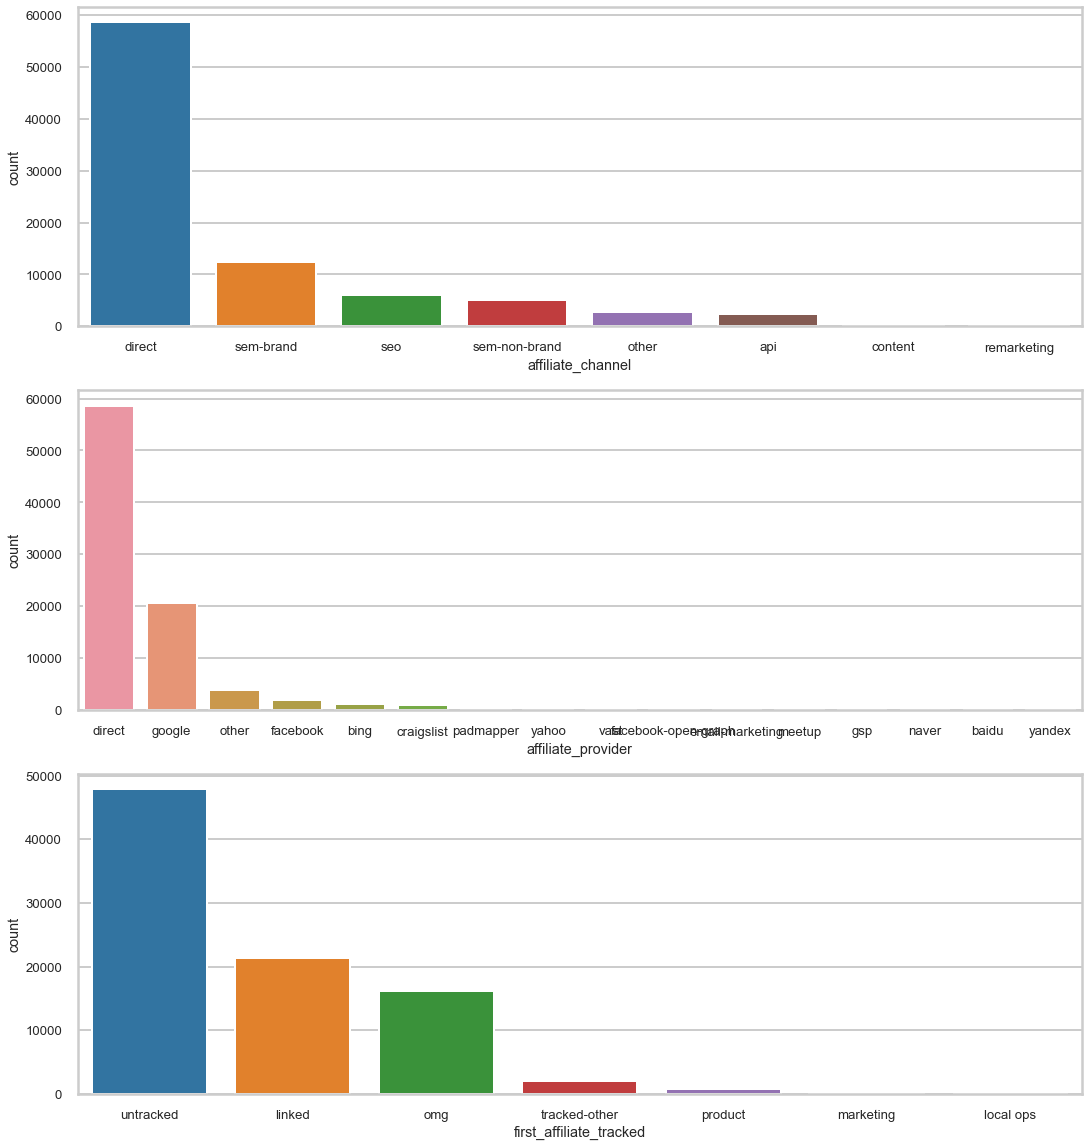

In [440]:
#affiliate_channel effect
plt.figure(figsize=(18,20))
plt.subplot(3, 1, 1)
#plt.xticks(rotation=90)
sns.countplot('affiliate_channel', order = df_copy2['affiliate_channel'].value_counts().index, data=df_copy2 )

plt.subplot(3, 1, 2)
#plt.xticks(rotation=90)
sns.countplot('affiliate_provider', order = df_copy2['affiliate_provider'].value_counts().index, data=df_copy2 )
plt.subplot(3, 1, 3)
#plt.xticks(rotation=90)
sns.countplot('first_affiliate_tracked', order = df_copy2['first_affiliate_tracked'].value_counts().index, data=df_copy2 )

In [441]:
#Aff.plot.bar(stacked=True ,figsize=(16, 8))
#Aff = df_copy2.groupby('country_destination')['affiliate_provider','first_affiliate_tracked','signup_method'].sum()

#plt.xlabel("Carrier", size=10)
#plt.ylabel("Delay")
#plt.title('Delay Distribution by Carrier', size=15)

In [442]:
df_copy2.signup_method.value_counts()

basic       50004
facebook    37861
google        322
weibo           7
Name: signup_method, dtype: int64

<Figure size 1440x1872 with 0 Axes>

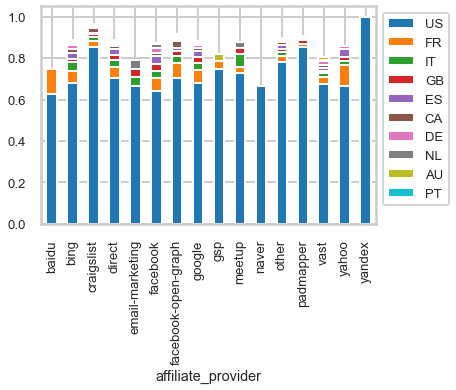

In [443]:
plt.figure(figsize=(20,26))
ctab = pd.crosstab([df_copy2['affiliate_provider']], df_copy2.country_destination).apply(lambda x: x/x.sum(), axis=1) #precentage to get the small values for providers
ctab[Country_order].plot(kind='bar', stacked=True)
#plt.legend(loc='lower right');
plt.legend(bbox_to_anchor=(1.0, 1.0));

dfa mn anhy country aktr? elly fo2 dafor us w fr a nzmo

<AxesSubplot:xlabel='country_destination', ylabel='count'>

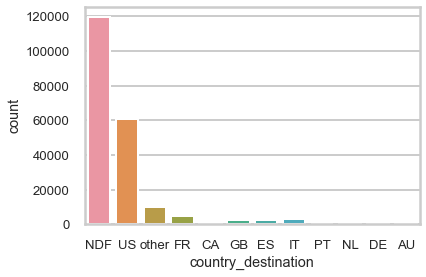

In [444]:
sns.countplot(x=df_copy[df_copy['language']=='en']['country_destination'])

df_copy2.affiliate_provider.value_counts()

In [445]:
df_copy2.affiliate_provider.value_counts()


direct                 58661
google                 20653
other                   3934
facebook                1951
bing                    1112
craigslist              1022
padmapper                226
yahoo                    175
vast                     169
facebook-open-graph      132
email-marketing           66
meetup                    35
gsp                       28
naver                     17
baidu                      8
yandex                     5
Name: affiliate_provider, dtype: int64

In [446]:
Final=df_copy2.copy()

In [447]:
Final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88194 entries, 2 to 62095
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       88194 non-null  object        
 1   date_account_created     88194 non-null  datetime64[ns]
 2   timestamp_first_active   88194 non-null  int64         
 3   gender                   88194 non-null  object        
 4   age                      88194 non-null  float64       
 5   signup_method            88194 non-null  object        
 6   signup_flow              88194 non-null  int64         
 7   language                 88194 non-null  object        
 8   affiliate_channel        88194 non-null  object        
 9   affiliate_provider       88194 non-null  object        
 10  first_affiliate_tracked  88194 non-null  object        
 11  signup_app               88194 non-null  object        
 12  first_device_type        88194 n

## Data Preprocessing and Modeling:
#### Encoding:

In [448]:
#Dropping unnecessary columns for moduling
Final.drop(['timestamp_first_active','AccCreat_year','AccCreat_Day','signup_app','date_account_created','id','signup_method','signup_flow','first_affiliate_tracked','first_affiliate_tracked','first_device_type','first_browser'],axis=1,inplace=True)

In [449]:
Final.shape

(88194, 7)

In [450]:
#Encoding categorical features
catg_features= ['gender','affiliate_channel', 'affiliate_provider','AccCreat_Month','language']

In [451]:
#I will use labelencoder for categorical data.

Encoder= LabelEncoder()
Encoded= Final[catg_features].apply(Encoder.fit_transform)

In [452]:
Encoded.sample(5)
#print(Encoded.shape)

,gender,affiliate_channel,affiliate_provider,AccCreat_Month,language
35328,0,2,3,7,5
119673,1,5,7,9,5
126351,0,2,3,10,5
173691,1,2,3,3,5
11637,1,2,3,6,5


In [453]:
temp=Final.drop(catg_features,axis=1)

In [454]:
df_Final= pd.concat([temp,Encoded],axis=1)
df_Final.head()

,age,country_destination,gender,affiliate_channel,affiliate_provider,AccCreat_Month,language
2,56.0,US,0,2,3,8,5
3,42.0,other,0,2,3,11,5
6,46.0,US,0,3,2,0,5
7,47.0,US,0,2,3,0,5
8,50.0,US,0,3,2,0,5


In [455]:
df_Final.country_destination.value_counts()

US       42267
other     6625
FR        3310
IT        1795
GB        1566
ES        1534
CA         937
DE         777
NL         535
AU         396
PT         148
Name: country_destination, dtype: int64

In [456]:
df_Final.shape

(88194, 7)

In [457]:
df_Final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88194 entries, 2 to 62095
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  88194 non-null  float64
 1   country_destination  59890 non-null  object 
 2   gender               88194 non-null  int32  
 3   affiliate_channel    88194 non-null  int32  
 4   affiliate_provider   88194 non-null  int32  
 5   AccCreat_Month       88194 non-null  int64  
 6   language             88194 non-null  int32  
dtypes: float64(1), int32(4), int64(1), object(1)
memory usage: 6.1+ MB


In [458]:
#seperate train data & test one
df_Final_train=df_Final[:59890]
df_Final_test=df_Final[59890:]

In [459]:
df_Final_test.country_destination

0        NaN
5        NaN
6        NaN
11       NaN
12       NaN
        ... 
62084    NaN
62085    NaN
62087    NaN
62089    NaN
62095    NaN
Name: country_destination, Length: 28304, dtype: object

In [460]:
duplicate_columns = df_Final_train.columns[df_Final_train.columns.duplicated()]
duplicate_columns

Index([], dtype='object')

In [461]:
X = df_Final_train.drop(columns=['country_destination'], axis=1).copy()
y = df_Final_train['country_destination'].copy()
#y_train = df_Final_train.iloc[:, df_Final_train.columns == 'country_destination']


In [462]:
label_encoder = LabelEncoder()
encoded_y_train = label_encoder.fit_transform(y) #Transforming the target variable using labels

In [463]:
#We see that the destination countries have been successfully encoded now
encoded_y_train

array([ 9, 10,  9, ...,  3,  9,  9])

In [464]:
X_train, X_test, y_train, y_test = train_test_split(X, encoded_y_train, test_size=0.3, random_state=42)

In [465]:
print(X.shape, X_train.shape, X_test.shape)

(59890, 6) (41923, 6) (17967, 6)


In [466]:
print(encoded_y_train.shape, y_train.shape, y_test.shape)

(59890,) (41923,) (17967,)


### Applying Algorithms
We will train our model using classifiers: KNN, Gradient Boosting, XGboost Regression since we have so many categorical fetures.

In [467]:
KNN = KNeighborsClassifier(n_neighbors = 20)
XGB = XGBClassifier(use_label_encoder=False)
GB = GradientBoostingClassifier()

In [468]:
# KNN model
KNN.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=20)

In [469]:
KNN.score(X_test, y_test)

0.7081872321478265

In [207]:
#k_range = range(1,50)
#scores = []

#for k in k_range:
#    knn = KNeighborsClassifier(n_neighbors = k)
#    knn.fit(X_train, y_train)
#    scores.append(knn.score(X_test, y_test))

#plt.figure()
#plt.xlabel('k')
#plt.ylabel('accuracy')
#plt.scatter(k_range, scores)
#plt.xticks([0,5,10,15,20]);

In [470]:
pred_knn = KNN.predict(X_test)
pred_knn

array([9, 9, 9, ..., 9, 9, 9])

In [365]:
#print(roc_auc_score(y_test,pred_knn))

In [471]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,pred_knn))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       125
           1       0.00      0.00      0.00       278
           2       0.00      0.00      0.00       241
           3       0.00      0.00      0.00       445
           4       0.00      0.00      0.00      1014
           5       0.00      0.00      0.00       457
           6       0.00      0.00      0.00       539
           7       0.00      0.00      0.00       156
           8       0.00      0.00      0.00        48
           9       0.71      1.00      0.83     12729
          10       0.11      0.00      0.00      1935

    accuracy                           0.71     17967
   macro avg       0.07      0.09      0.08     17967
weighted avg       0.51      0.71      0.59     17967



C:\Users\AbouElNasrA\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AbouElNasrA\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AbouElNasrA\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


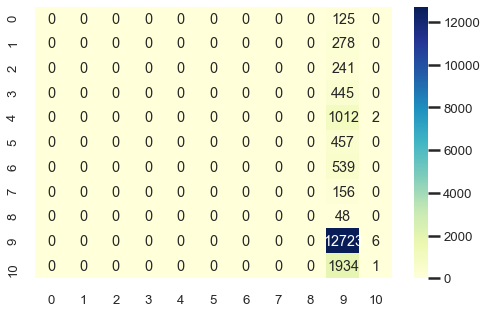

In [472]:
cm=confusion_matrix(y_test,pred_knn)
conf_matrix=pd.DataFrame(data=cm)
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");

In [473]:
#GradientBoosting
GB.fit(X_train,y_train)

GradientBoostingClassifier()

In [474]:
GB.score(X_test, y_test)

0.7074636834196026

In [475]:
##Applying xgboost
XGB.fit(X_train,y_train)

[20:15:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [476]:
pred_XGB=XGB.predict(X_test)
pred_XGB

array([9, 9, 9, ..., 9, 9, 9], dtype=int64)

In [477]:
XGB.score(X_test, y_test)

0.7059052707741972

In [478]:
print(classification_report(y_test,pred_XGB))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       125
           1       0.00      0.00      0.00       278
           2       0.00      0.00      0.00       241
           3       0.00      0.00      0.00       445
           4       0.33      0.00      0.01      1014
           5       0.20      0.00      0.00       457
           6       0.00      0.00      0.00       539
           7       0.00      0.00      0.00       156
           8       0.00      0.00      0.00        48
           9       0.71      1.00      0.83     12729
          10       0.18      0.00      0.01      1935

    accuracy                           0.71     17967
   macro avg       0.13      0.09      0.08     17967
weighted avg       0.55      0.71      0.59     17967



C:\Users\AbouElNasrA\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AbouElNasrA\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AbouElNasrA\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [540]:
#Specifying the hyperparameters

xgb = XGBClassifier(max_depth=6, learning_rate=0.02, n_estimators=43,
                    objective='multi:softprob', subsample=0.6, colsample_bytree=0.5, seed=1)                  
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

C:\Users\AbouElNasrA\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:49:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [541]:
xgb.score(X_test, y_test)

0.7084655201202203

In [542]:
print(classification_report(y_test,y_pred_xgb))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       125
           1       0.00      0.00      0.00       278
           2       0.00      0.00      0.00       241
           3       0.00      0.00      0.00       445
           4       0.00      0.00      0.00      1014
           5       0.00      0.00      0.00       457
           6       0.00      0.00      0.00       539
           7       0.00      0.00      0.00       156
           8       0.00      0.00      0.00        48
           9       0.71      1.00      0.83     12729
          10       0.00      0.00      0.00      1935

    accuracy                           0.71     17967
   macro avg       0.06      0.09      0.08     17967
weighted avg       0.50      0.71      0.59     17967



C:\Users\AbouElNasrA\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AbouElNasrA\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AbouElNasrA\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


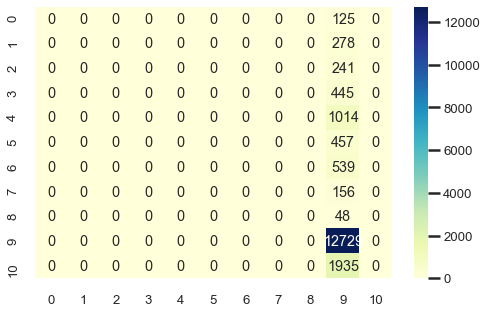

In [543]:
cm_xgb=confusion_matrix(y_test,y_pred_xgb)
conf_matrix_xgb=pd.DataFrame(data=cm_xgb)
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix_xgb, annot=True,fmt='d',cmap="YlGnBu");

Specifying more xgboost model parameter was a little helpful for model score

In [366]:
#Specifying the hyperparameters
'''
import xgboost as xgb
xg_train = xgb.DMatrix(X, label=encoded_y_train) 
params = {'max_depth': 10,
    'learning_rate': 1,
    'n_estimators': 5,
    'objective': 'multi:softprob',
    'num_class': 12,
    'gamma': 0,
    'min_child_weight': 1,
    'max_delta_step': 0,
    'subsample': 1,
    'colsample_bytree': 1,
    'colsample_bylevel': 1,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'scale_pos_weight': 1,
    'base_score': 0.5,
    'missing': None,
    'nthread': 4,
    'seed': 42
          }

num_boost_round = 5

print("Train a XGBoost model")
gbm = xgb.train(params, xg_train, num_boost_round)
'''

'\nimport xgboost as xgb\nxg_train = xgb.DMatrix(X, label=encoded_y_train) \nparams = {\'max_depth\': 10,\n    \'learning_rate\': 1,\n    \'n_estimators\': 5,\n    \'objective\': \'multi:softprob\',\n    \'num_class\': 12,\n    \'gamma\': 0,\n    \'min_child_weight\': 1,\n    \'max_delta_step\': 0,\n    \'subsample\': 1,\n    \'colsample_bytree\': 1,\n    \'colsample_bylevel\': 1,\n    \'reg_alpha\': 0,\n    \'reg_lambda\': 1,\n    \'scale_pos_weight\': 1,\n    \'base_score\': 0.5,\n    \'missing\': None,\n    \'nthread\': 4,\n    \'seed\': 42\n          }\n\nnum_boost_round = 5\n\nprint("Train a XGBoost model")\ngbm = xgb.train(params, xg_train, num_boost_round)\n'

#### let's see XGboost feature imporance

In [179]:
xgb.feature_importances_

array([0.16253392, 0.1646479 , 0.16754737, 0.17745353, 0.1574156 ,
       0.17040163], dtype=float32)

In [180]:
def plot_feature_importance(feature_columns, importance_values,top_n_features=0):
    feature_imp = [ col for col in zip(feature_columns, importance_values)]
    feature_imp.sort(key=lambda x:x[1], reverse=True)

    if top_n_features:
        imp = pd.DataFrame(feature_imp[0:top_n_features], columns=['feature', 'importance'])
    else:
        imp = pd.DataFrame(feature_imp, columns=['feature', 'importance'])
    plt.figure(figsize=(10, 8))
    sns.barplot(y='feature', x='importance', data=imp, orient='h')
    plt.title('Most Important Features', fontsize=16)
    plt.ylabel("Feature", fontsize=16)
    plt.xlabel("")
    plt.show()

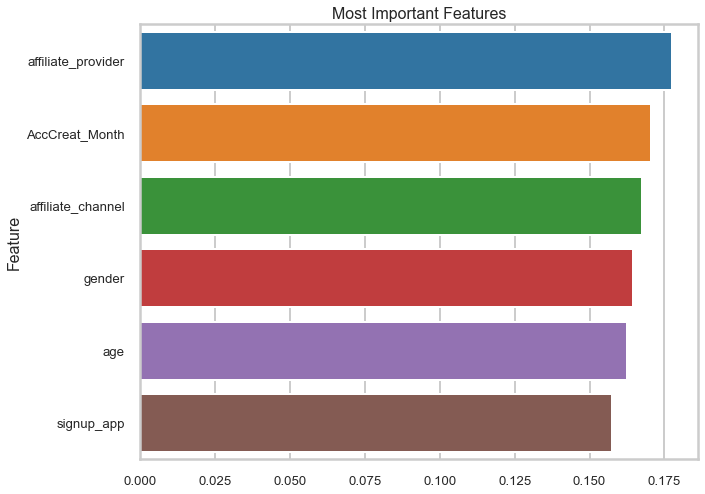

In [181]:
plot_feature_importance(['age','gender','affiliate_channel', 'affiliate_provider','signup_app','AccCreat_Month'], XGB.feature_importances_)

It seems like affiliate_provider and account creation month features are playing very good role at xgb modeling, age does too which was predicted.

In [532]:
from sklearn.ensemble import RandomForestClassifier
RF= RandomForestClassifier(verbose=1)
RF.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.1s finished


RandomForestClassifier(verbose=1)

In [533]:
RF.score(X_test, y_test) 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished


0.6780764735348138

In [534]:
y_pred_RF= RF.predict(X_test)
print(classification_report(y_test,y_pred_RF))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       125
           1       0.00      0.00      0.00       278
           2       0.08      0.01      0.02       241
           3       0.06      0.01      0.02       445
           4       0.08      0.01      0.02      1014
           5       0.06      0.01      0.02       457
           6       0.06      0.01      0.02       539
           7       0.00      0.00      0.00       156
           8       0.00      0.00      0.00        48
           9       0.71      0.95      0.81     12729
          10       0.11      0.02      0.04      1935

    accuracy                           0.68     17967
   macro avg       0.11      0.09      0.09     17967
weighted avg       0.53      0.68      0.58     17967



[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished


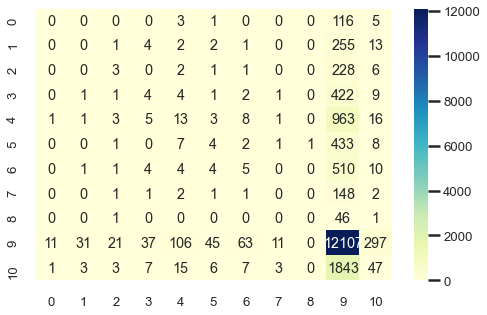

In [535]:
cm_RF=confusion_matrix(y_test,y_pred_RF)
conf_matrix_RF=pd.DataFrame(data=cm_RF)
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix_RF, annot=True,fmt='d',cmap="YlGnBu");

Random Forest model shows yet less accuracy but consistant behaivior over all country destinations.

#### another question of mine, what would happen using same model if I didn't apply much cleaning like leaving many NDF included into the data, would it affect positively on the accuracy score?

In [489]:
df_train_1= df_Final_train.copy()

In [492]:
#df_train_1.drop(['id','signup_method','signup_app','signup_flow','first_affiliate_tracked','first_affiliate_tracked','first_device_type','first_browser'],axis=1,inplace=True)
cat_features= ['gender','affiliate_channel', 'affiliate_provider','language','AccCreat_Month']
df_train_1.shape

(59890, 7)

In [493]:
df_train_1.shape

(59890, 7)

In [494]:
encoder= LabelEncoder()
encoded= df_train_1[cat_features].apply(encoder.fit_transform)

In [495]:
temp1=df_train_1.drop(cat_features,axis=1)

In [496]:
df_1= pd.concat([temp1,encoded],axis=1)
df_1.head()

,age,country_destination,gender,affiliate_channel,affiliate_provider,language,AccCreat_Month
2,56.0,US,0,2,3,5,8
3,42.0,other,0,2,3,5,11
6,46.0,US,0,3,2,5,0
7,47.0,US,0,2,3,5,0
8,50.0,US,0,3,2,5,0


In [498]:
#df_1.drop(['date_first_booking'],axis=1,inplace=True)
#df_1.head()

In [499]:
df_1.age.fillna(value = Value,inplace=True)

In [500]:
df_1.isna().sum()

age                    0
country_destination    0
gender                 0
affiliate_channel      0
affiliate_provider     0
language               0
AccCreat_Month         0
dtype: int64

In [501]:
x1 = df_1.drop(columns=['country_destination'], axis=1).copy()
y1 = df_1['country_destination'].copy()

x1.shape

(59890, 6)

In [502]:
y1.shape

(59890,)

In [503]:
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.3, random_state=42)

In [504]:
xgb.fit(x1_train,y1_train)

C:\Users\AbouElNasrA\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:29:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=43, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=1, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=1, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [505]:
xgb.score(x1_test, y1_test)

0.7084655201202203

In [506]:
y1_pred = xgb.predict(x1_test)

In [507]:
print(classification_report(y1_test,y1_pred))

C:\Users\AbouElNasrA\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AbouElNasrA\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AbouElNasrA\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       125
          CA       0.00      0.00      0.00       278
          DE       0.00      0.00      0.00       241
          ES       0.00      0.00      0.00       445
          FR       0.00      0.00      0.00      1014
          GB       0.00      0.00      0.00       457
          IT       0.00      0.00      0.00       539
          NL       0.00      0.00      0.00       156
          PT       0.00      0.00      0.00        48
          US       0.71      1.00      0.83     12729
       other       0.00      0.00      0.00      1935

    accuracy                           0.71     17967
   macro avg       0.06      0.09      0.08     17967
weighted avg       0.50      0.71      0.59     17967



In [510]:
#not showing big difference

In [509]:
#RF.fit(x1_train,y1_train)

In [508]:
#RF.score(x1_test,y1_test)

In [363]:
#df_Final_test.drop(['country_destination'], axis = 1, inplace= True)

## Predicting on the test set

In [521]:
df_Final_test.head()

,age,gender,affiliate_channel,affiliate_provider,AccCreat_Month,language
0,35.0,0,2,3,6,5
5,28.0,0,5,7,6,5
6,48.0,1,2,3,6,5
11,30.0,0,2,3,6,5
12,24.0,1,2,3,6,5


In [516]:
df_Final_test.drop('country_destination', axis = 1,inplace= True)

C:\Users\AbouElNasrA\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [524]:
y_pred_test = RF.predict(df_Final_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished


In [525]:
y_pred_df = pd.DataFrame(y_pred_test)
y_pred_df.value_counts()

9     27056
10      522
6       178
4       156
5       129
3       101
1        80
2        60
7        17
8         3
0         2
dtype: int64

In [544]:
#y_pred_df_gb = pd.DataFrame(y_pred_test_gb)
#y_pred_df_gb.value_counts()

In [ ]:
y_series=pd.Series(y_pred)

In [530]:
#y_pred_test_XGB = XGB.predict(df_Final_test)

In [ ]:
#df["col1"].replace(di, inplace=True)

In [298]:
'''
class_dict = {
    'NDF': 0,
    'US': 1,
    'other': 2,
    'FR': 3,
    'CA': 4,
    'GB': 5,
    'ES': 6,
    'IT': 7,
    'PT': 8,
    'NL': 9,
    'DE': 10,
    'AU': 11
}
'''

In [355]:
#pd.get_dummies(y_pred_df)

In [361]:
#y_pred_df.apply(lambda x: class_dict[x])
#y_pred_df = y_pred_df.mask(axis=0, class_dict)
#y_pred_df.replace({"0": class_dict})
#y_seri.map(class_dict)

In [358]:

#for i in y_pred_df.shape[0]:
    #if i in class_dict.keys:
#    print(i)

In [359]:
#y1_test.shape

In [360]:
#y_seri.shape